# Χρήστος Ζαχαριουδάκης - 03400132 - ΕΔΕΜΜ

# **Μη επιβλεπόμενη μάθηση: μελέτη dataset της σουίτας "clustering_benchmarks_v1"**

## **Ανάγνωση του μικρού dataset**

In [1]:
!pip install wget
!pip install -U numpy --upgrade --ignore-installed

  Using cached wget-3.2-py3-none-any.whl


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.21.5 which is incompatible.


In [2]:
import wget
import numpy as np

github = "https://github.com/gagolews/clustering_benchmarks_v1/raw/master/"

dataset = "wut/cross"  # e.g., "wut/x1"
data_url = github + dataset + ".data.gz"
labels_url = github + dataset + ".labels0.gz"

wget.download(data_url)
wget.download(labels_url)

# load data into a numpy array
Xsmall = np.loadtxt(dataset.split("/")[1]+".data.gz", ndmin=2)
print(Xsmall)
print(Xsmall.shape)
print(type(Xsmall))

# Load the corresponding reference labels. The original labels are in {1,2,..,k}.
# We'll make them more Python-ish by subtracting 1.
ysmall = np.loadtxt(dataset.split("/")[1]+".labels0.gz", dtype=np.intc) - 1
print(ysmall)

# The number of unique labels gives the true cluster count:
n_clusters_small = len(np.unique(ysmall))
unique, counts = np.unique(ysmall, return_counts=True)
print(dict(zip(unique, counts)))
print("True number of clusters: ",n_clusters_small)

100% [....................................................................................] 72 / 72[[ 2.394544  2.394544]
 [ 0.684135  0.684135]
 [ 0.524568  0.524568]
 ...
 [ 1.615928 -1.615928]
 [ 6.40739  -6.40739 ]
 [ 0.524944 -0.524944]]
(2000, 2)
<class 'numpy.ndarray'>
[0 0 0 ... 3 3 3]
{0: 500, 1: 500, 2: 500, 3: 500}
True number of clusters:  4


## **Ανάγνωση του μεγάλου dataset**

In [3]:
import wget
import numpy as np

github = "https://github.com/gagolews/clustering_benchmarks_v1/raw/master/"

dataset = "h2mg/h2mg_128_70" 
data_url = github + dataset + ".data.gz"
labels_url = github + dataset + ".labels0.gz"

wget.download(data_url)
wget.download(labels_url)

# load data into a numpy array
Xbig = np.loadtxt(dataset.split("/")[1]+".data.gz", ndmin=2)
print(Xbig)
print(Xbig.shape)
print(type(Xbig))

# Load the corresponding reference labels. The original labels are in {1,2,..,k}.
# We'll make them more Python-ish by subtracting 1.
ybig = np.loadtxt(dataset.split("/")[1]+".labels0.gz", dtype=np.intc) - 1
print(ybig)

# The number of unique labels gives the true cluster count:
n_clusters_big = len(np.unique(ybig))
unique, counts = np.unique(ybig, return_counts=True)
print(dict(zip(unique, counts)))
print("True number of clusters: ",n_clusters_big)

100% [....................................................................................] 70 / 70[[1326. -259.  285. ...  706. -118.  120.]
 [ 916.    5. -375. ... -985. 1152.  429.]
 [ 636.  527.  507. ...  268.  199.  297.]
 ...
 [ 330.  117. -234. ... -578.  468.  948.]
 [ 680.   70.  469. ...  152.  637.  891.]
 [ 670.  446. 1277. ...  598.  721.  801.]]
(2048, 128)
<class 'numpy.ndarray'>
[0 0 0 ... 1 1 1]
{0: 1024, 1: 1024}
True number of clusters:  2


## **Εγκατάσταση και εισαγωγή βιβλιοθηκών**

Στο σημείο αυτό θα εγκαταστήσουμε ορισμένες βιβλιοθήκες που περιέχουν τους αλγορίθμους συσταδοποίησης που θα χρησιμοποιήσουμε:

In [4]:
!pip install scikit-learn fastcluster hdbscan sklearn-som matplotlib

  Using cached fastcluster-1.2.4-cp39-cp39-win_amd64.whl (36 kB)
  Using cached hdbscan-0.8.27-cp39-cp39-win_amd64.whl
  Using cached sklearn_som-1.1.0-py3-none-any.whl (6.7 kB)


Στην συνέχεια, εισάγουμε τους ταξινομητές που θα εφαρμόσουμε στα δύο dataset. 

In [5]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn_som.som import SOM
import fastcluster
import matplotlib.pyplot as plt

Θα εφαρμόσουμε τους ταξινοτητές στα δύο dataset και θα αξιολογήσουμε την απόδοση των clusters με βάση τις παρακάτω μετρικές:

*   Adjusted Rand Index: Ποσοστό ομοιότητας μεταξυ προβλέψεων και ετικετών, αγνοώντας την σειρά τους, με διόρθωση για την περίπτωση τυχαίας ομοιότητας
*   Adjusted Mutual Information: Υπολογίζει την αλληλοεξάρτηση δύο μεταβλητών/διανυσμάτων, αγνοώντας την σειρά τους, με διόρθωση για την περίπτωση τυχαίας ομοιότητας
*   V-measure = $\frac{(1 + \beta) \times \text{homogeneity} \times \text{completeness}}{(\beta \times \text{homogeneity} + \text{completeness})}$,  όπου homogeneity αναπαριστά το ποσοστό των clusters που περιέχουν μόνο δεδομένα που ανήκουν σε μια συγκεκριμένη κλάση και completeness αναπαριστά το ποσοστό των δειγμάτων που είναι μέλη μιας συγκεκριμένης κλάσης και είναι ταυτόχρονα στοιχεία του ίδιου cluster. 

τις οποίες θα λάβουμε από to scikit-learn.

In [6]:
from sklearn import metrics

## **Εφαρμογή αλγορίθμων**

### **Μικρό Dataset**

#### **K-means**

=========== Real number of clusters = 4 ===========
======================== k-Means =======================
{0: 195, 1: 1418, 2: 195, 3: 192}
Adjusted Rand index: 0.10892439510479873
Adjusted Mutual information: 0.36415761173433825
V-measure: 0.365402263350265


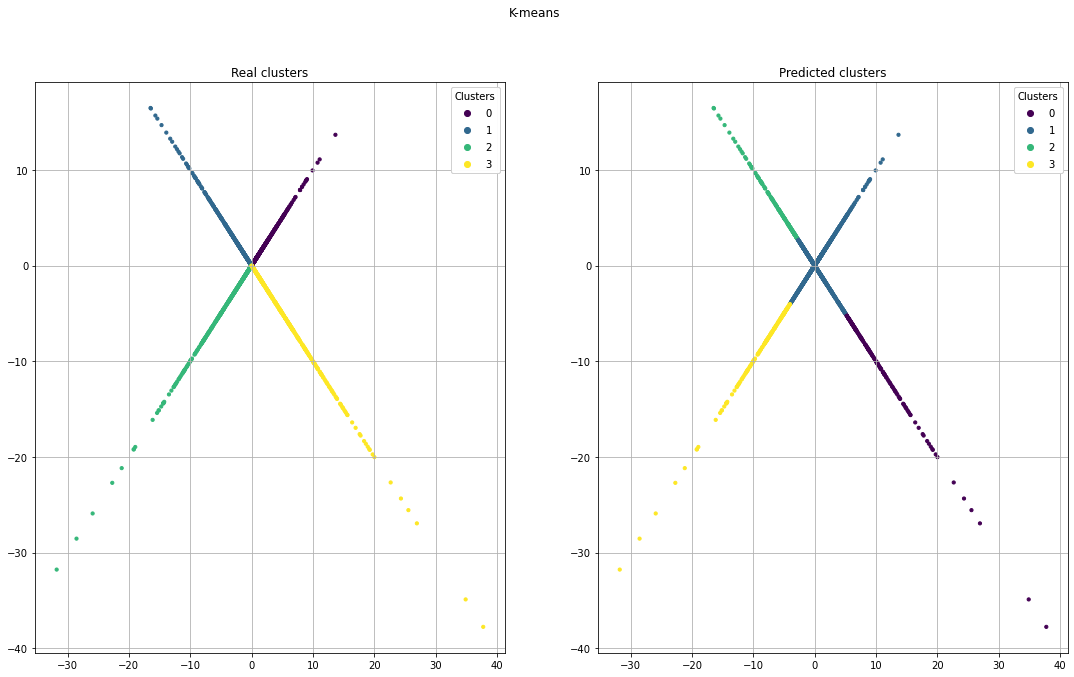

In [7]:
print("=========== Real number of clusters = {} ===========".format(n_clusters_small))

print("======================== k-Means =======================")
kmeans = KMeans(n_clusters = n_clusters_small, random_state=42).fit(Xsmall)
y_pred = kmeans.predict(Xsmall)
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))
print("Adjusted Rand index:",metrics.adjusted_rand_score(ysmall, y_pred))
print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ysmall, y_pred))
print("V-measure:",metrics.v_measure_score(ysmall, y_pred))
print("========================================================")

fig, axs = plt.subplots(1,2)
fig.suptitle('K-means')
fig.set_size_inches(18.5, 10.5)

scatter = axs[0].scatter(Xsmall[:,0],Xsmall[:,1], c=ysmall,  s=10)

# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
axs[0].add_artist(legend1)
axs[0].grid(True)
axs[0].set_title('Real clusters')

###########################################################

axs[1].set_title('Predicted clusters')

scatter = axs[1].scatter(Xsmall[:,0],Xsmall[:,1], c=y_pred,  s=10)

# produce a legend with the unique colors from the scatter
legend2 = axs[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
axs[1].add_artist(legend2)
axs[1].grid(True)

plt.show()

Παρατηρούμε ότι στην πρόβλεψη ορισμένα από τα δείγματα των Clusters 1,2,3 έχουν ταξινομηθεί στο Cluster 0. Επίσης έχουν αντιστραφεί τα Clusters 1 και 3, αλλά επειδή έχουμε Clusters και όχι classes, δεν μας απασχολεί αυτό. Κατα τα άλλα, το clustering δεν έχει λειτουργήσει τόσο άσχημα.

#### **Hierarchical Agglomerative Clustering (HAC)**

======== Method 'single' ========
{0: 2, 1: 2, 2: 1995, 3: 1}
Adjusted Rand index: 4.019398292080369e-06
Adjusted Mutual information: 0.00148656358263697
V-measure: 0.004933308086130077




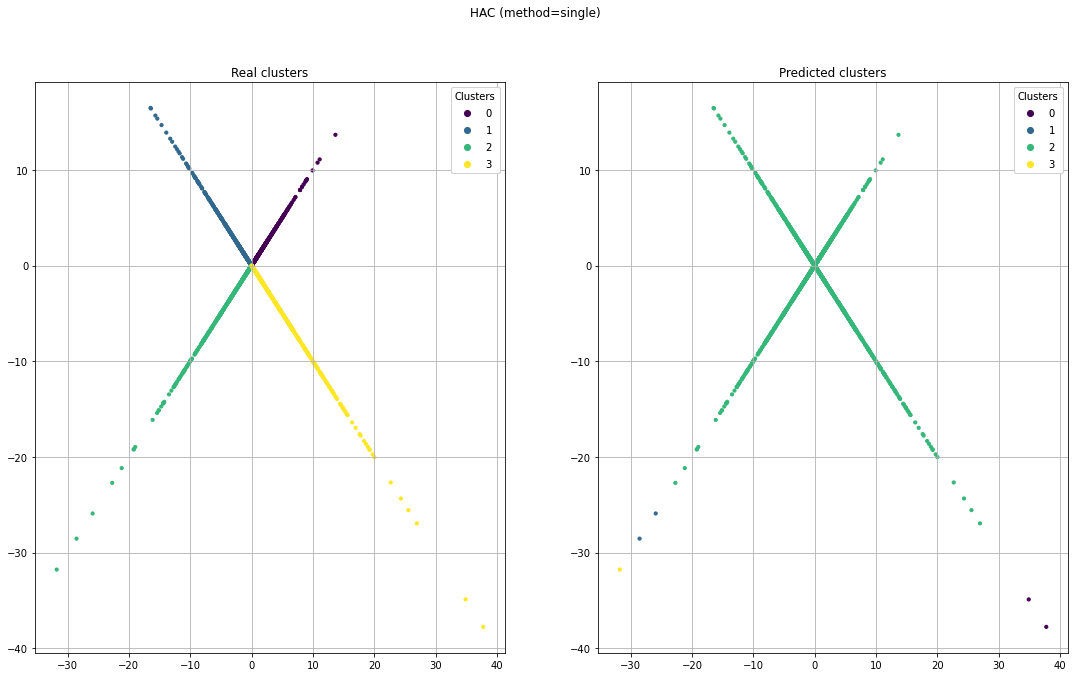

======== Method 'average' ========
{0: 2, 1: 3, 2: 36, 3: 1959}
Adjusted Rand index: 0.001338705437288696
Adjusted Mutual information: 0.03541502933720301
V-measure: 0.03871867018946082




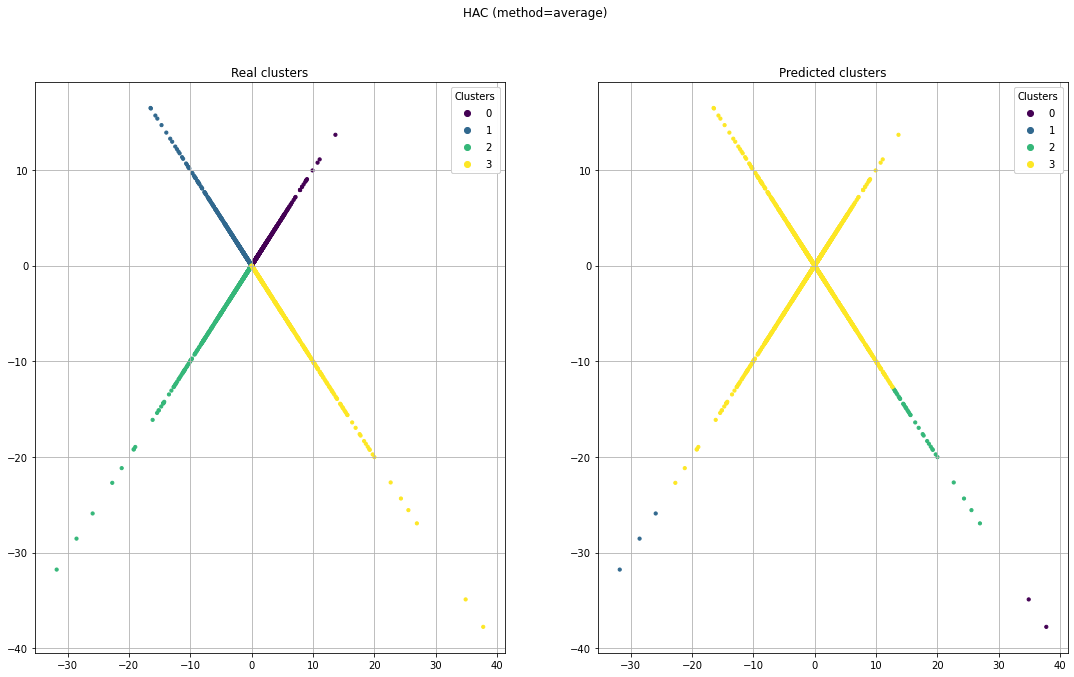

======== Method 'complete' ========
{0: 85, 1: 8, 2: 779, 3: 1128}
Adjusted Rand index: 0.35873073211016737
Adjusted Mutual information: 0.47571596530197957
V-measure: 0.4768394192125328




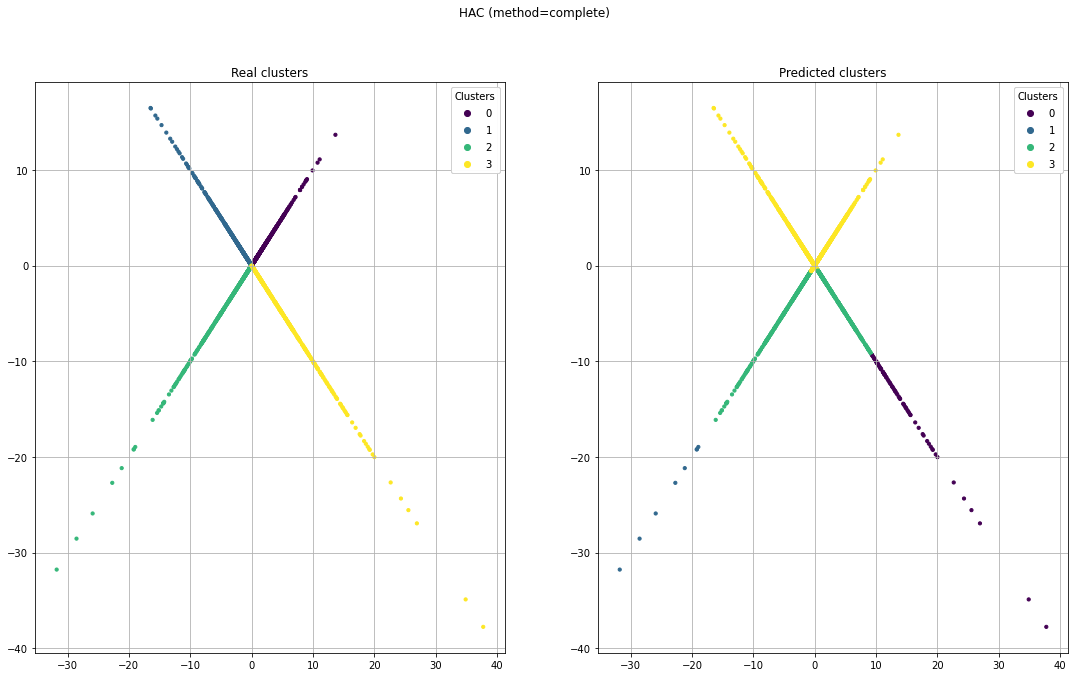

======== Method 'ward' ========
{0: 173, 1: 192, 2: 103, 3: 1532}
Adjusted Rand index: 0.07246065208813923
Adjusted Mutual information: 0.3093601529956854
V-measure: 0.3107942800442569




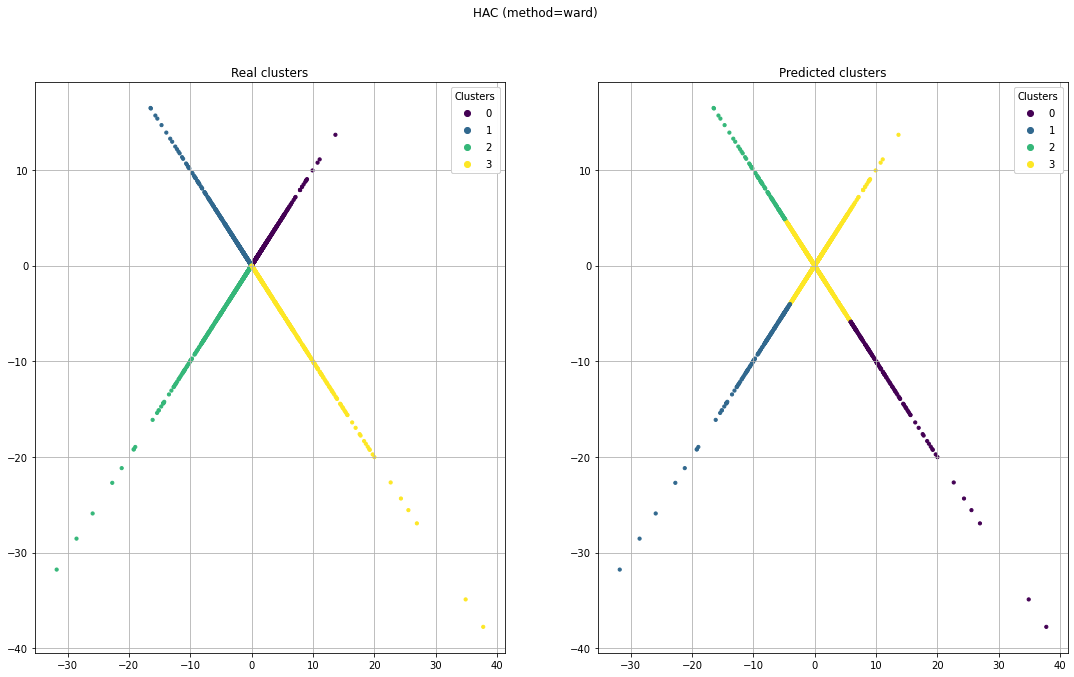

In [8]:
import scipy
methods = ['single','average','complete','ward']

for method in methods:
  print ("======== Method '{}' ========".format(method))
  tree = fastcluster.linkage(Xsmall,method= method)
  y_pred = scipy.cluster.hierarchy.fcluster(tree,t= n_clusters_small, criterion ='maxclust' ) # Return prediction_labels
  y_pred = [i-1 for i in y_pred]
  unique, counts = np.unique(y_pred, return_counts=True)
  print(dict(zip(unique, counts)))
  print("Adjusted Rand index:",metrics.adjusted_rand_score(ysmall, y_pred))
  print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ysmall, y_pred))
  print("V-measure:",metrics.v_measure_score(ysmall, y_pred))
  print('\n')

  fig, axs = plt.subplots(1,2)
  fig.suptitle('HAC (method={})'.format(method))
  fig.set_size_inches(18.5, 10.5)

  scatter = axs[0].scatter(Xsmall[:,0],Xsmall[:,1], c=ysmall,  s=10)

  # produce a legend with the unique colors from the scatter
  legend1 = axs[0].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
  axs[0].add_artist(legend1)
  axs[0].grid(True)
  axs[0].set_title('Real clusters')

  ###########################################################

  axs[1].set_title('Predicted clusters')

  scatter = axs[1].scatter(Xsmall[:,0],Xsmall[:,1], c=y_pred,  s=10)

  # produce a legend with the unique colors from the scatter
  legend2 = axs[1].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
  axs[1].add_artist(legend2)
  axs[1].grid(True)

  plt.show()

*   **Single** : Όπως μας προδιαθέτουν οι πολύ μικρές τιμές των μετρικών, το clustering απέτυχε σε αυτή την περίπτωση, καθώς ταξινόμησε όλα τα δείγματα σε ένα cluster εκτός απο 5 που τοποθέτησε στα άλλα τρία cluster.
*   **Average** : Στην μέθοδο αυτή έχουμε παρόμοια αποτελεσματα, με ένα μικρό μέρος των δειγμάτων (36), να εχει τοποθετηθεί σε ξεχωριστό cluster. Ωστόσο, δυο cluster εχουν πάρει 2 και 3 δείγματα αντίστοιχα, ενώ όλα τα άλλα δείγματα έχουν ταξινομηθεί σε ενα cluster.
*   **Complete** : Στην μέθοδο αυτή παρατηρούμε βελτίωση. Το πράσινο cluster εχει ταξινομηθεί σωστά, αλλά έχει πάρει και δείγματα που θα έπρεπε να ανήκουν στο μπλε cluster. Λογω αυτού το μπλε cluster έχει λάβει μέρος των δειγματων που θα έπρεπε να έχει. Ωστόσο το κίτρινο cluster έχει λάβει τις τιμές που κανονικά ανήκουν σε δυο clusters. H μέθοδος αυτή μας δίνει τις καλύτερες μετρικές.
*   **Ward** : Η μέθοδος με τα καλύτερα αποτελέσματα. Περισσότερα δείγματα εχουν ταξινομηθεί σωστά, αλλά το κίτρινο cluster εχει λάβει πάρα πολλα δείγματα, που δεν του αντιστοιχούν, από όλα τα άλλα clusters. H μέθοδος αυτή μας δίνει τις δεύτερες καλύτερες μετρικές.

#### **Gaussian Mixture Model**

============== GMM =============
{0: 36, 1: 1000, 2: 727, 3: 237}
Adjusted Rand index: 0.48730159217886754
Adjusted Mutual information: 0.6259373503041452
V-measure: 0.6266383976077483


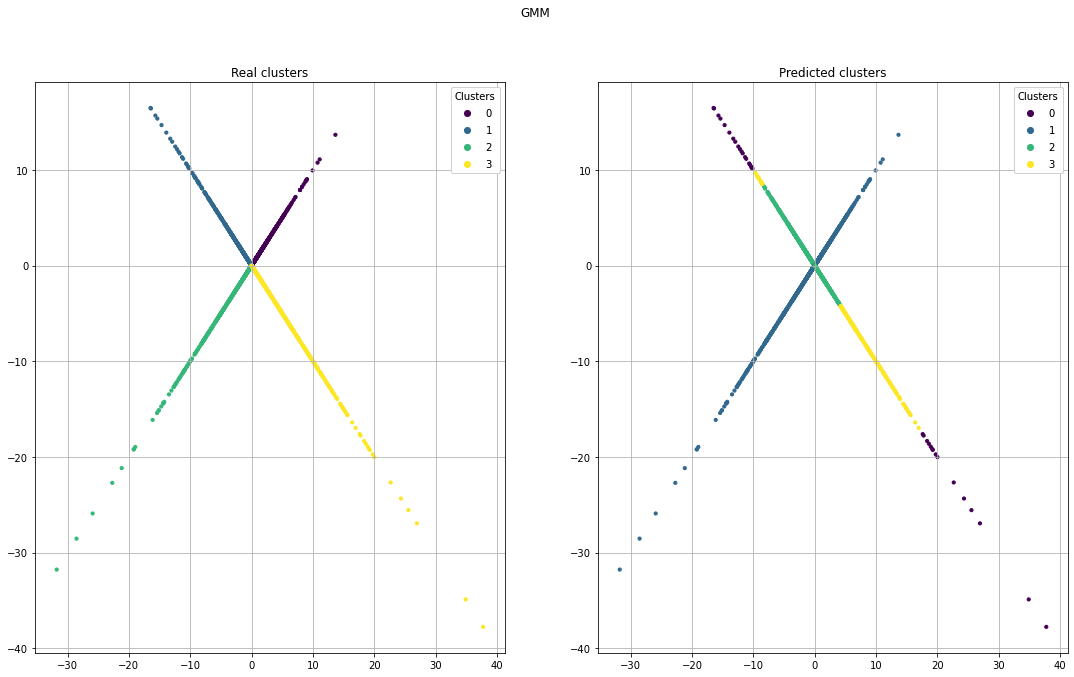

In [9]:
print("============== GMM =============")
gm = GaussianMixture(n_components = n_clusters_small + 1, random_state=42).fit(Xsmall)
y_pred = gm.predict(Xsmall)
y_pred = [i-1 for i in y_pred]
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))
print("Adjusted Rand index:",metrics.adjusted_rand_score(ysmall, y_pred))
print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ysmall, y_pred))
print("V-measure:",metrics.v_measure_score(ysmall, y_pred))
print("================================")

fig, axs = plt.subplots(1,2)
fig.suptitle('GMM')
fig.set_size_inches(18.5, 10.5)

scatter = axs[0].scatter(Xsmall[:,0],Xsmall[:,1], c=ysmall,  s=10)

# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[0].add_artist(legend1)
axs[0].grid(True)
axs[0].set_title('Real clusters')

###########################################################

axs[1].set_title('Predicted clusters')

scatter = axs[1].scatter(Xsmall[:,0],Xsmall[:,1], c=y_pred,  s=10)

# produce a legend with the unique colors from the scatter
legend2 = axs[1].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[1].add_artist(legend2)
axs[1].grid(True)

plt.show()


H μέθοδος των GMM δίνει πολύ καλές μετρικές σε σχέση με τους προηγούμενους αλγορίθμους, αλλά μέτρια αποτελέσματα. Το μπλέ cluster λαμβάνει τα δικά του δείγματα και αυτά ενός άλλου cluster, το πράσινο λαμβάνει μόνο ένα μέρος των σημείων που του αναλογούν και κάποια που δεν του ανήκουν, ενώ το κίτρινο λαμβανει μόνο ένα μέρος των σημείων που του αναλογούν. Τα λίγα σημεία που απομένουν τα λαμβάνει το μωβ cluster, σημεία από όλα τα clusters.

#### **DBSCAN**

============ DBSCAN ============
{0: 6, 1: 1985, 2: 5, 3: 4}
Adjusted Rand index: 3.912456123304095e-05
Adjusted Mutual information: 0.00642039431099286
V-measure: 0.010267672172329932


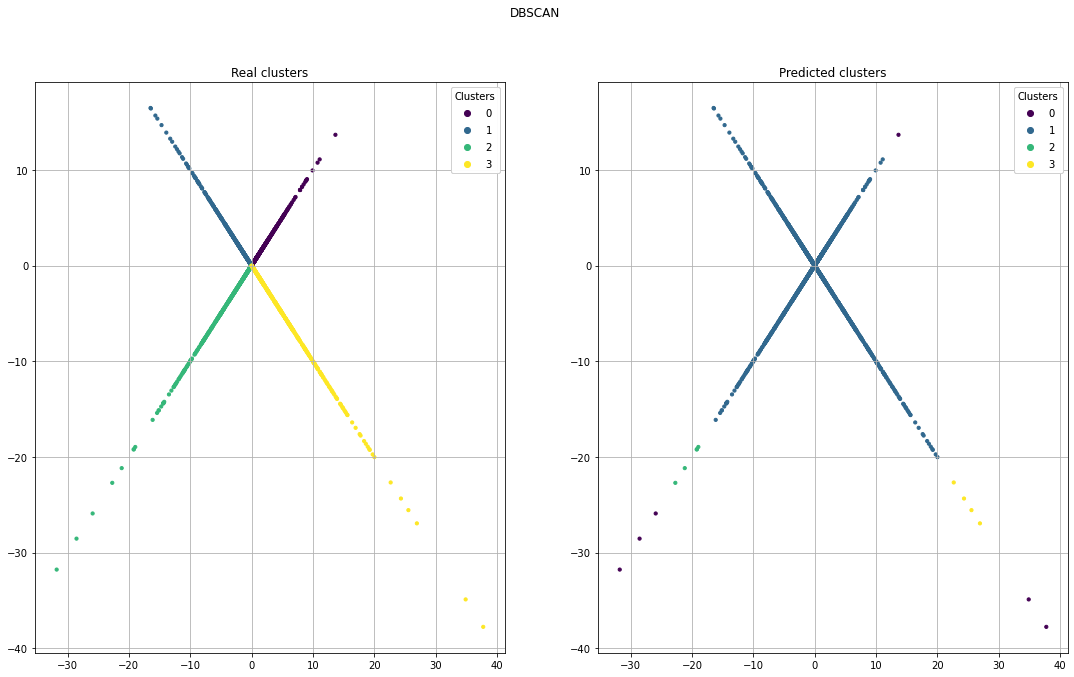

In [10]:
print("============ DBSCAN ============")
y_pred = DBSCAN(eps=3, min_samples=2).fit_predict(Xsmall)
y_pred = [i+1 for i in y_pred]
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))
print("Adjusted Rand index:",metrics.adjusted_rand_score(ysmall, y_pred))
print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ysmall, y_pred))
print("V-measure:",metrics.v_measure_score(ysmall, y_pred))
print("================================")

fig, axs = plt.subplots(1,2)
fig.suptitle('DBSCAN')
fig.set_size_inches(18.5, 10.5)

scatter = axs[0].scatter(Xsmall[:,0],Xsmall[:,1], c=ysmall,  s=10)

# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[0].add_artist(legend1)
axs[0].grid(True)
axs[0].set_title('Real clusters')

###########################################################

axs[1].set_title('Predicted clusters')
scatter = axs[1].scatter(Xsmall[:,0],Xsmall[:,1], c=y_pred,  s=10)

# produce a legend with the unique colors from the scatter
legend2 = axs[1].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[1].add_artist(legend2)
axs[1].grid(True)

plt.show()

Το DBSCAN δίνει πολύ χαμηλές μετρικές και αναλόγως λανθασμένο clustering, ένα cluster λαμβάνει σχεδόν όλα τα δείγματα και τα άλλα 3 ελάχιστα.

#### **HDBSCAN**

=========== HDBSCAN ===========
{0: 586, 1: 47, 2: 48, 3: 1319}
Number of clusters : 4
Adjusted Rand index: 0.032674321324586475
Adjusted Mutual information: 0.08824956035692119
V-measure: 0.0901406035452723


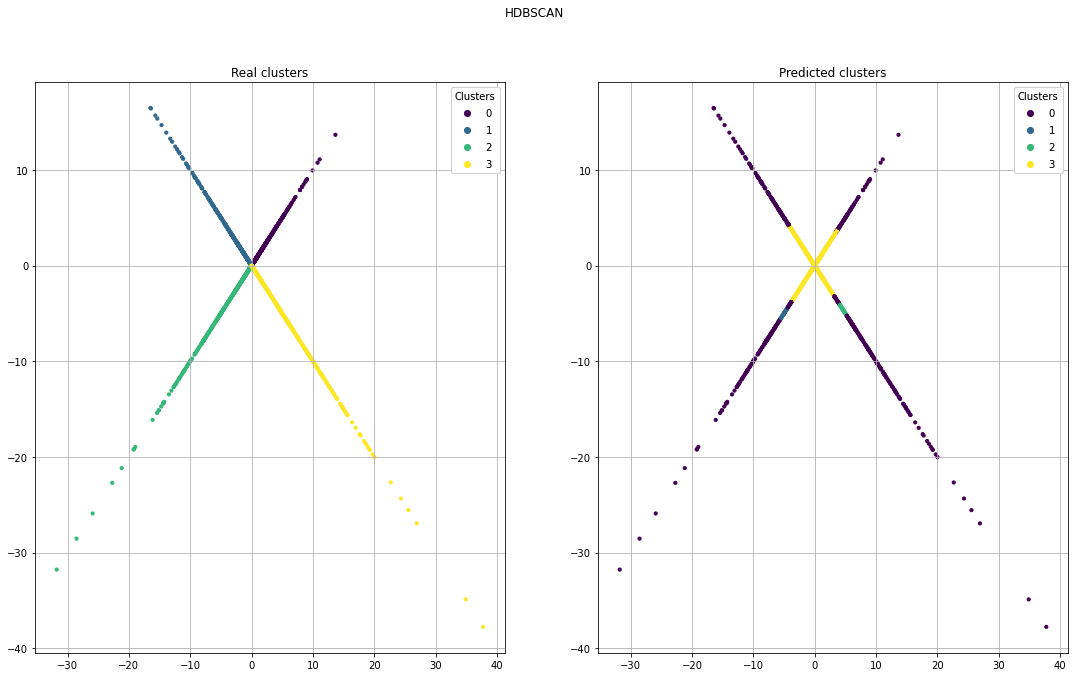

In [11]:
print("=========== HDBSCAN ===========")
clusterer = hdbscan.HDBSCAN(min_cluster_size=40)
y_pred = clusterer.fit_predict(Xsmall)
y_pred = [i+1 for i in y_pred]
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))
print("Number of clusters : {}".format(len(set(y_pred))))
print("Adjusted Rand index:",metrics.adjusted_rand_score(ysmall, y_pred))
print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ysmall, y_pred))
print("V-measure:",metrics.v_measure_score(ysmall, y_pred))
print("================================")

fig, axs = plt.subplots(1,2)
fig.suptitle('HDBSCAN')
fig.set_size_inches(18.5, 10.5)

scatter = axs[0].scatter(Xsmall[:,0],Xsmall[:,1], c=ysmall,  s=10)

# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[0].add_artist(legend1)
axs[0].grid(True)
axs[0].set_title('Real clusters')

###########################################################

axs[1].set_title('Predicted clusters')

scatter = axs[1].scatter(Xsmall[:,0],Xsmall[:,1], c=y_pred,  s=10)

# produce a legend with the unique colors from the scatter
legend2 = axs[1].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[1].add_artist(legend2)
axs[1].grid(True)

plt.show()


Λίγο καλύτερο απο το DBSCAN, αλλά πάλι έχουμε χαμηλές μετρικές και πολύ μέτρια αποτελέσματα, καθώς πάλι σχεδόν όλα τα δείγματα ταξινομούνται σε ένα cluster (Κίτρινο (3)).

#### **SOM**

============= SOM ==============
{0: 315, 1: 779, 2: 634, 3: 272}
Adjusted Rand index: 0.5181776283050419
Adjusted Mutual information: 0.6185910226151661
V-measure: 0.6192330564206486


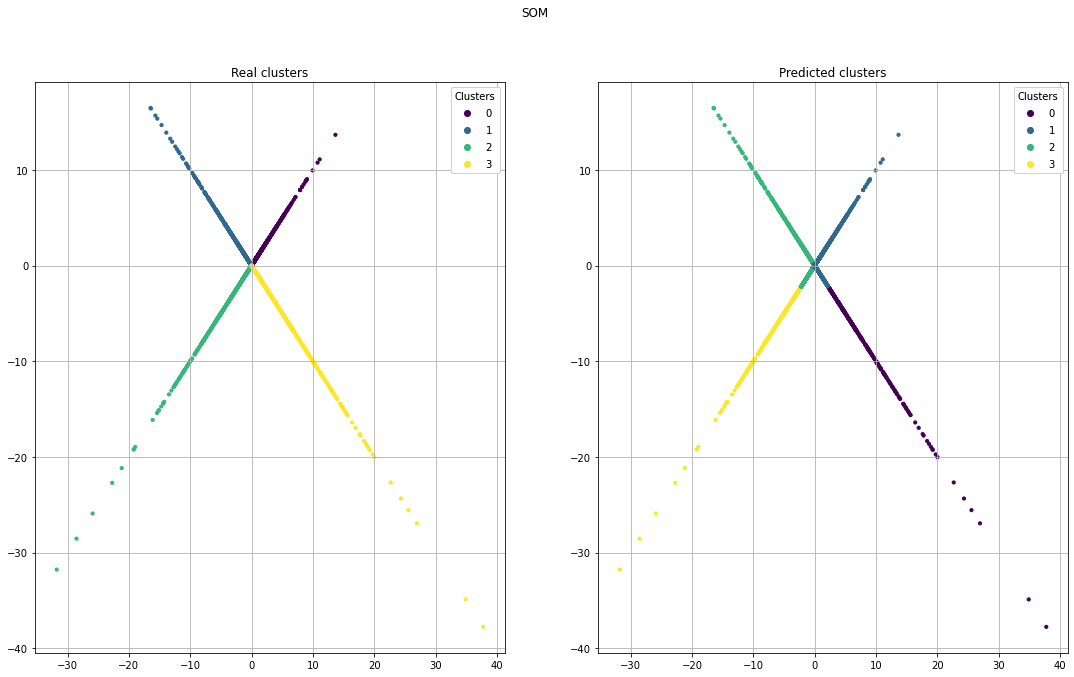

In [12]:
print("============= SOM ==============")
som = SOM(m=n_clusters_small, n=1, dim=2)
som.fit(Xsmall)
y_pred = som.predict(Xsmall)
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))
print("Adjusted Rand index:",metrics.adjusted_rand_score(ysmall, y_pred))
print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ysmall, y_pred))
print("V-measure:",metrics.v_measure_score(ysmall, y_pred))

print("================================")

fig, axs = plt.subplots(1,2)
fig.suptitle('SOM')
fig.set_size_inches(18.5, 10.5)

scatter = axs[0].scatter(Xsmall[:,0],Xsmall[:,1], c=ysmall,  s=10)

# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[0].add_artist(legend1)
axs[0].grid(True)
axs[0].set_title('Real clusters')

###########################################################

axs[1].set_title('Predicted clusters')

scatter = axs[1].scatter(Xsmall[:,0],Xsmall[:,1], c=y_pred,  s=10)

# produce a legend with the unique colors from the scatter
legend2 = axs[1].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[1].add_artist(legend2)
axs[1].grid(True)

plt.show()

Ο αλγόριθμος SOM δίνει καλές σχετικά μετρικές και καλό σχετικά clustering. Τα clusters 0 και 1 εχουν ταξινομηθεί σχεδόν τέλεια, αλλα τα περισσότερα δείγματα που λαμβάνει το cluster 2 δεν είναι δικά του και το cluster 3 έχει λάβει σχεδόν όλα τα δείγματα που του αναλογούν μαζί με τα δείγματα που θα έπρεπε να ανήκουν στο cluster 2.

Στη συνέχεια, θα παρουσιάσουμε σε ένα πίνακα markdown, τις τιμές των μετρικών για όλους τους αλγορίθμους:

| Ταξινομητές | Adjusted Rand Index |Adjusted Mutual Information |V-measure |
| --- | --- |--- | --- |
| k-Means | 10.89% |36.41% |36.54% |
| HAC (Single) | 0 |0.14% |0.49% |
| HAC (Average) | 0.13% |3.5% |3.8% |
| HAC (Complete) | 35.87% |47.57% |47.68% |
| HAC (Ward) | 7.24% |30.93% |31.07% |
| GMM | 48.73% |62.59% |62.66% |
| DBSCAN| 0 |0.64% |1% |
| HDBSCAN | 3.2% | 8.88% |9.01% |
| SOM | 31.82% | 48.62% |48.71% |

Με βάση τα παραπάνω αποτελέσματα ο χειρότερος αλγόριθμος είναι o HAC με μέθοδο Single και ο καλύτερος είναι το Gaussian Mixture Model. Θα υπολογίσουμε και θα σχεδιάσουμε το πίνακα σύγχυσης για τους δύο αλγορίθμους.

======== HAC 'Single' ========
[[  0   0 500   0]
 [  0   0 500   0]
 [  0   2 497   1]
 [  2   0 498   0]]
============== GMM =============
[[  0 500   0   0]
 [ 21   0 463  16]
 [  0 500   0   0]
 [ 15   0 264 221]]


Text(0.5, 1.0, 'Best algorithm (GMM) confusion matrix')

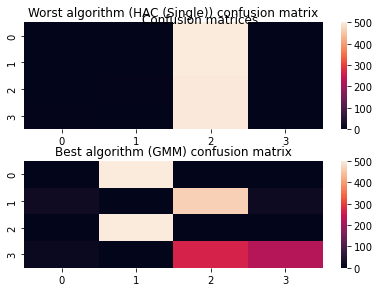

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import fastcluster

print ("======== HAC 'Single' ========")
tree = fastcluster.linkage(Xsmall,method= 'single')
worst = scipy.cluster.hierarchy.fcluster(tree,t= n_clusters_small, criterion ='maxclust') # Return prediction_labels
worst = [i-1 for i in worst]
w_conf = confusion_matrix(ysmall, worst)
print(w_conf,end='\n')

print("============== GMM =============")
gm = GaussianMixture(n_components = n_clusters_small + 1, random_state=42).fit(Xsmall)
best = gm.predict(Xsmall)
best = [i-1 for i in best]
b_conf = confusion_matrix(ysmall, best)
print(b_conf,end='\n')

fig, axs = plt.subplots(2,1)
fig.tight_layout()
fig.suptitle('Confusion matrices')
sns.heatmap(w_conf,ax = axs[0])
axs[0].set_title('Worst algorithm (HAC (Single)) confusion matrix')
sns.heatmap(b_conf,ax = axs[1])
axs[1].set_title('Best algorithm (GMM) confusion matrix')

Με βάση τις επιδόσεις τους, θα προτείναμε τον αλγόριθμο Gaussian Mixture Model για clustering, αν και κανενός η απόδοση δεν είναι ιδανική.

### **Μεγάλο Dataset**

Αντίθετα με το προηγούμενο dataset, που είχε μονο 2 διαστάσεις/χαρακτηριστικά, αυτό το dataset εχει 128 χαρακτηριστικά. Οι παρακάτω απεικονίσεις αφορούν τα μόνο τα πρώτα δύο χαρακτηριστικά, αλλά τo clustering θα γίνεται χρησιμοποιώντας όλα τα χαρακτηριστικά. Λόγω της μεγάλης αύξησης της διαστατικότητας, αναμένουμε το clustering να μην αποδίδει τόσο καλά.

#### **K-means**

=========== Real number of clusters = 2 ===========
======================== k-Means =======================
{0: 1025, 1: 1023}
Clustering time 0.04099297523498535s
Adjusted Rand index: 0.42654728799665786
Adjusted Mutual information: 0.33447784952807624
V-measure: 0.3347124319695491


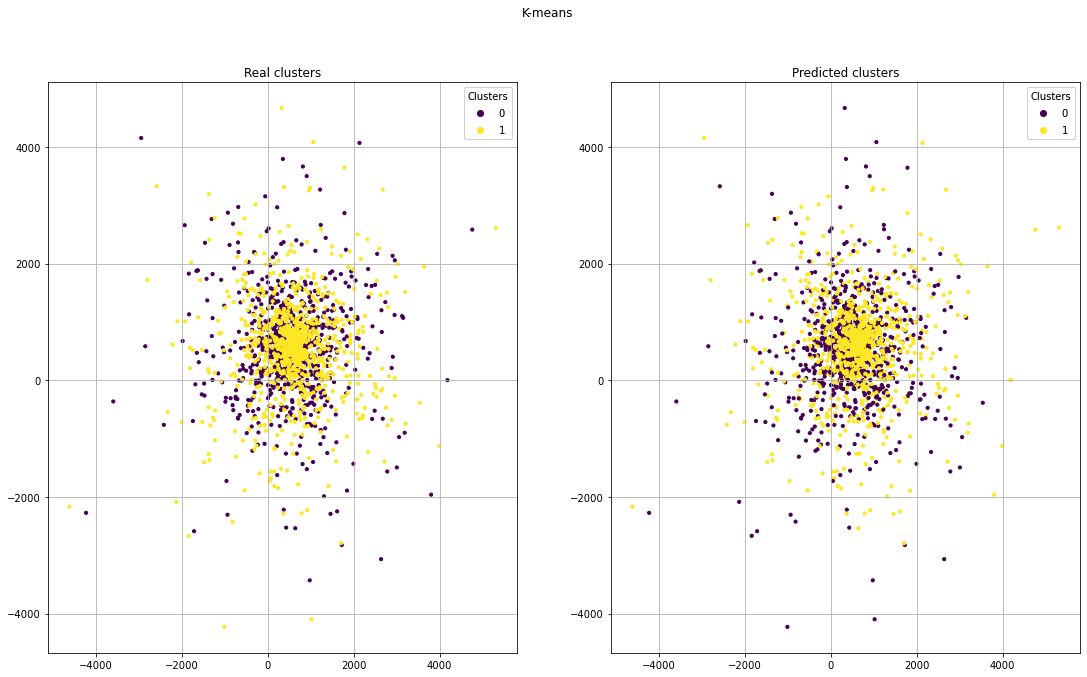

In [14]:
print("=========== Real number of clusters = {} ===========".format(n_clusters_big))
import time

print("======================== k-Means =======================")
start = time.time()
kmeans = KMeans(n_clusters = n_clusters_big, random_state=42).fit(Xbig)
y_pred = kmeans.predict(Xbig)
end = time.time()
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))
print("Clustering time {}s".format(end-start))
print("Adjusted Rand index:",metrics.adjusted_rand_score(ybig, y_pred))
print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ybig, y_pred))
print("V-measure:",metrics.v_measure_score(ybig, y_pred))
print("========================================================")

fig, axs = plt.subplots(1,2)
fig.suptitle('K-means')
fig.set_size_inches(18.5, 10.5)

scatter = axs[0].scatter(Xbig[:,0],Xbig[:,1], c=ybig,  s=10)

# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
axs[0].add_artist(legend1)
axs[0].grid(True)
axs[0].set_title('Real clusters')

###########################################################

axs[1].set_title('Predicted clusters')

scatter = axs[1].scatter(Xbig[:,0],Xbig[:,1], c=y_pred,  s=10)

# produce a legend with the unique colors from the scatter
legend2 = axs[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
axs[1].add_artist(legend2)
axs[1].grid(True)

plt.show()

Οι μετρικές είναι καλές σε σχέση με τις παρακάτω περιπτώσεις και το clustering φαίνεται να έχει γίνει σχετικά καλά, καθώς τα δείγματα είναι ισοκατανεμημένα στα δύο clusters ({0: 1025, 1: 1023}), όπως θα έπρεπε να είναι ({0: 1024, 1: 1024}), ακόμη και εάν επικαλύπτονται στις 2 πρώτες διαστάσεις. Ωστόσο οι μετρικές μας δείχνουν, ότι παρόλο που τα clusters περιέχουν τον σωστό αριθμό δειγμάτων, έχουν ομαδοποιηθεί μαζί αρκετά δείγματα τα οποία δεν ανήκουν μαζί.

#### **Hierarchical Agglomerative Clustering (HAC)**

======== Method 'single' ========
{0: 2047, 1: 1}
Clustering time 0.12000107765197754s
Adjusted Rand index: 0.0
Adjusted Mutual information: 2.374820230328942e-16
V-measure: 0.0009710074111617752




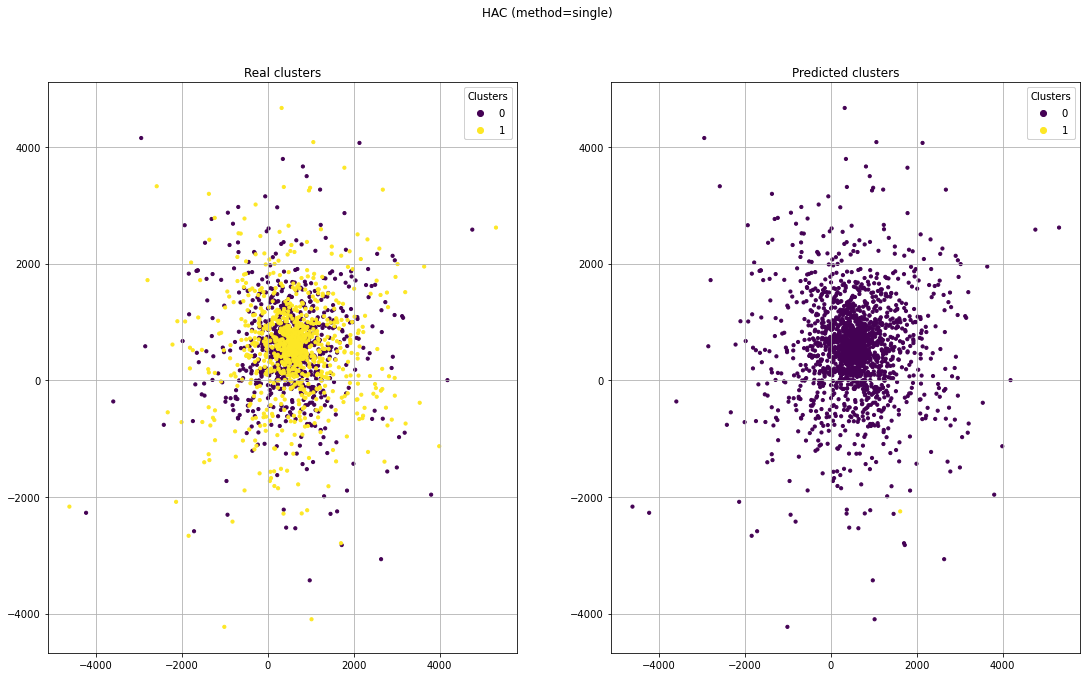

======== Method 'average' ========
{0: 2047, 1: 1}
Clustering time 0.13299989700317383s
Adjusted Rand index: 0.0
Adjusted Mutual information: 2.374820230328942e-16
V-measure: 0.0009710074111617752




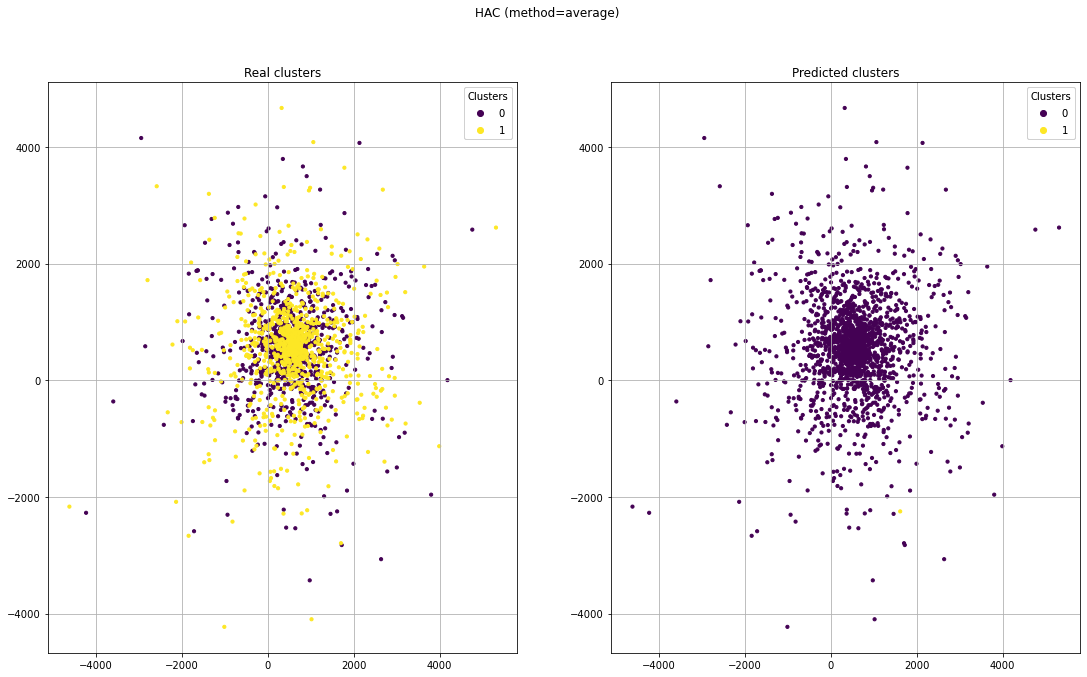

======== Method 'complete' ========
{0: 2, 1: 2046}
Clustering time 0.15100789070129395s
Adjusted Rand index: 1.9082840483414938e-06
Adjusted Mutual information: 0.0009678592057802235
V-measure: 0.001932904284277497




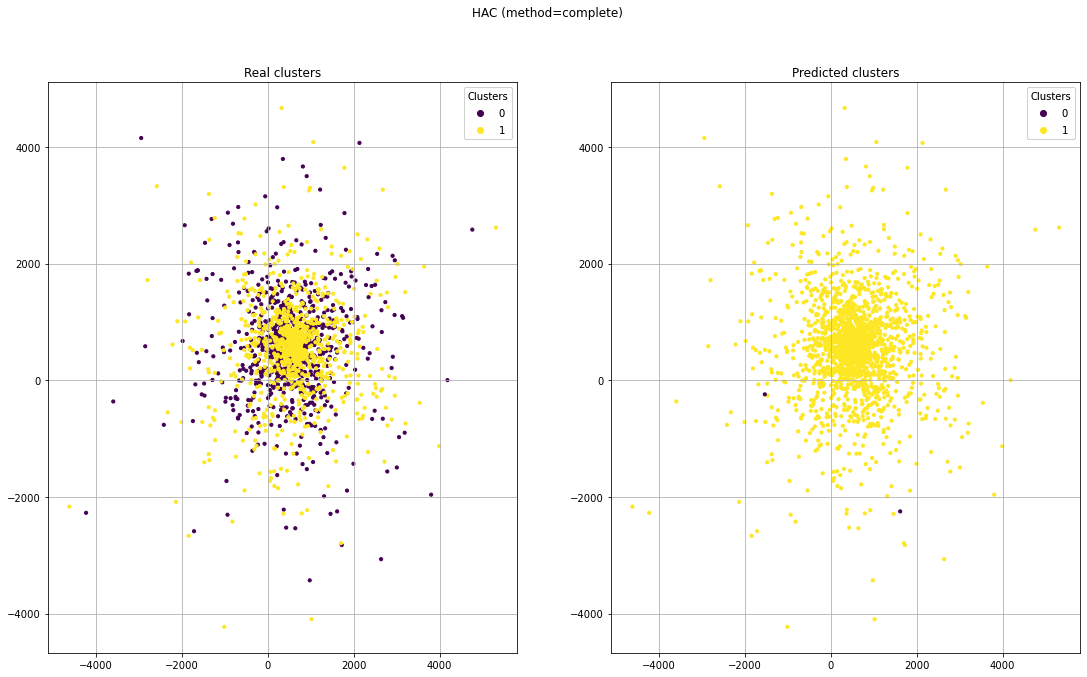

======== Method 'ward' ========
{0: 2047, 1: 1}
Clustering time 0.1380016803741455s
Adjusted Rand index: 0.0
Adjusted Mutual information: 2.374820230328942e-16
V-measure: 0.0009710074111617752




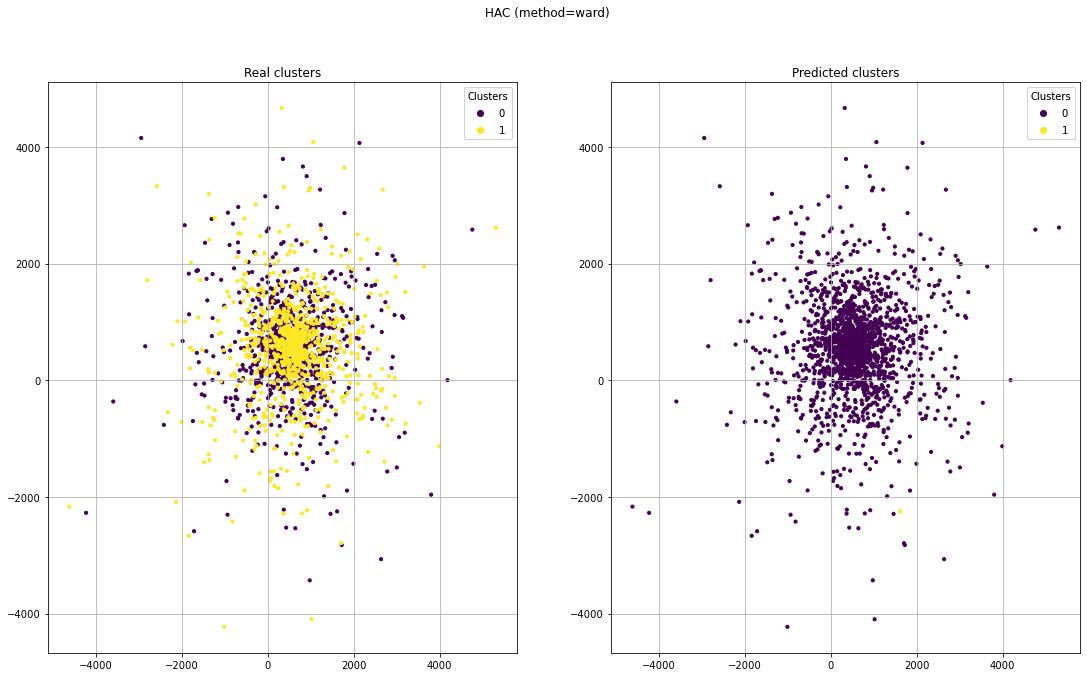

In [15]:
import scipy
methods = ['single','average','complete','ward']

for method in methods:
  print ("======== Method '{}' ========".format(method))
  start = time.time()
  tree = fastcluster.linkage(Xbig,method= method)
  y_pred = scipy.cluster.hierarchy.fcluster(tree,t= n_clusters_big, criterion ='maxclust' ) # Return prediction_labels
  end = time.time()
  y_pred = [i-1 for i in y_pred]
  unique, counts = np.unique(y_pred, return_counts=True)
  print(dict(zip(unique, counts)))
  print("Clustering time {}s".format(end-start))
  print("Adjusted Rand index:",metrics.adjusted_rand_score(ybig, y_pred))
  print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ybig, y_pred))
  print("V-measure:",metrics.v_measure_score(ybig, y_pred))
  print('\n')

  fig, axs = plt.subplots(1,2)
  fig.suptitle('HAC (method={})'.format(method))
  fig.set_size_inches(18.5, 10.5)

  scatter = axs[0].scatter(Xbig[:,0],Xbig[:,1], c=ybig,  s=10)

  # produce a legend with the unique colors from the scatter
  legend1 = axs[0].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
  axs[0].add_artist(legend1)
  axs[0].grid(True)
  axs[0].set_title('Real clusters')

  ###########################################################

  axs[1].set_title('Predicted clusters')

  scatter = axs[1].scatter(Xbig[:,0],Xbig[:,1], c=y_pred,  s=10)

  # produce a legend with the unique colors from the scatter
  legend2 = axs[1].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
  axs[1].add_artist(legend2)
  axs[1].grid(True)

  plt.show()

To clustering έχει γίνει τελείως λανθασμένα σε όλες τις περιπτώσεις με τα δείγματα να κατανέμονται σχεδόν όλα σε ενα cluster.

#### **Gaussian Mixture Model**

============== GMM =============
{0: 1, 1: 2047}
Clustering time 0.06599688529968262s
Adjusted Rand index: 0.0
Adjusted Mutual information: 2.3732639916458956e-16
V-measure: 0.0009710074111617752


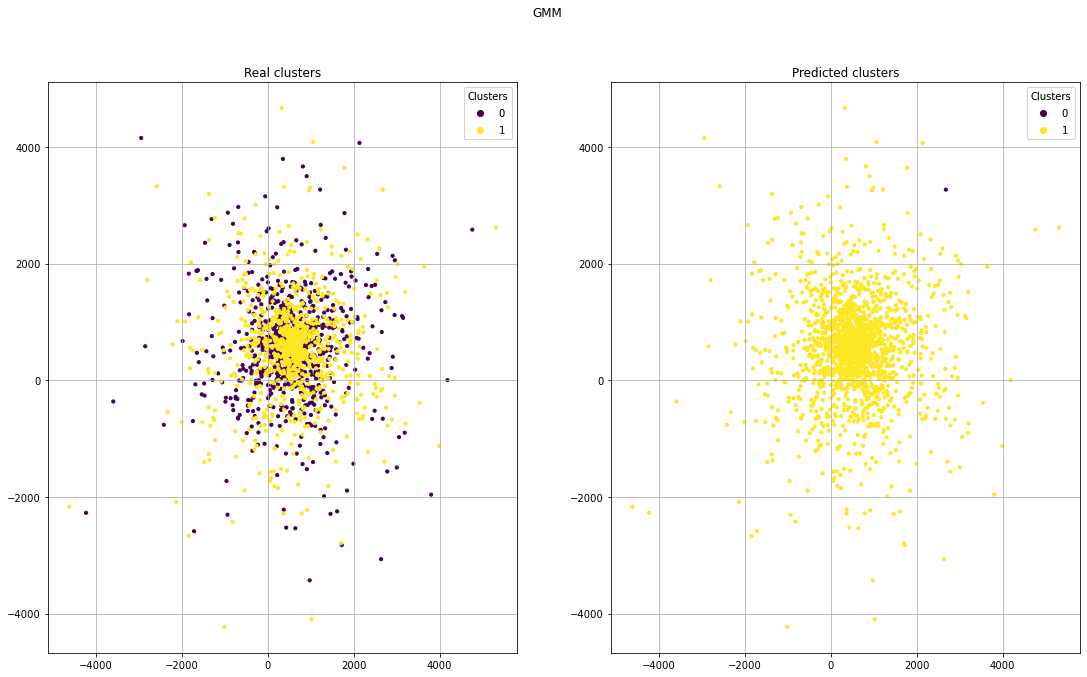

In [16]:
print("============== GMM =============")
start = time.time()
gm = GaussianMixture(n_components = n_clusters_big , random_state=42).fit(Xbig)
y_pred = gm.predict(Xbig)
end = time.time()
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))
print("Clustering time {}s".format(end-start))
print("Adjusted Rand index:",metrics.adjusted_rand_score(ybig, y_pred))
print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ybig, y_pred))
print("V-measure:",metrics.v_measure_score(ybig, y_pred))
print("================================")

fig, axs = plt.subplots(1,2)
fig.suptitle('GMM')
fig.set_size_inches(18.5, 10.5)

scatter = axs[0].scatter(Xbig[:,0],Xbig[:,1], c=ybig,  s=10)

# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[0].add_artist(legend1)
axs[0].grid(True)
axs[0].set_title('Real clusters')

###########################################################

axs[1].set_title('Predicted clusters')

scatter = axs[1].scatter(Xbig[:,0],Xbig[:,1], c=y_pred,  s=10)

# produce a legend with the unique colors from the scatter
legend2 = axs[1].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[1].add_artist(legend2)
axs[1].grid(True)

plt.show()


H μέθοδος των GMM δεν λειτουργεί καλά, καθώς ταξινομεί ολα τα δείγματα σε ένα cluster. Αυτό φαίνεται τόσο απο την απεικόνιση όσο και απο τις μετρικές. Προφανώς, λόγω της εγγύτητας των δειγμάτων (τουλάχιστον στις 2 πρώτες διαστάσεις), δεν μπορεί να διακρίνει σε ποια Gaussian ανήκει κάθε δείγμα.

#### **DBSCAN**

============ DBSCAN ============
{0: 2046, 1: 2}
Clustering time 0.06399941444396973s
Adjusted Rand index: 1.9082840483414938e-06
Adjusted Mutual information: 0.0009678592057802235
V-measure: 0.001932904284277497


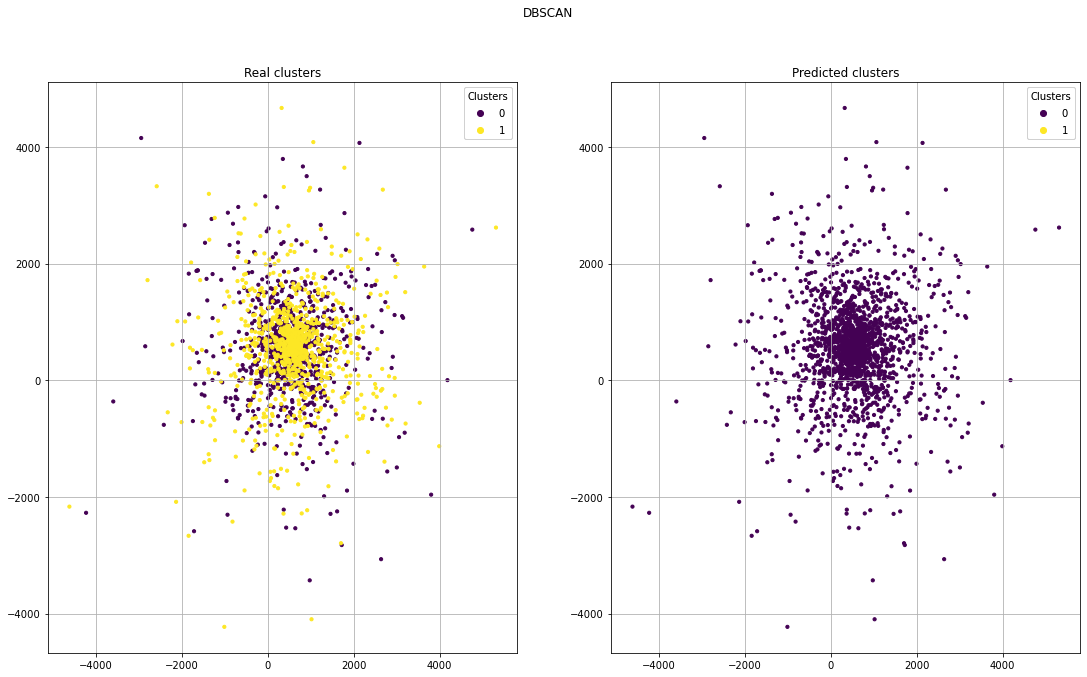

In [17]:
print("============ DBSCAN ============")
start = time.time()
y_pred = DBSCAN(eps=3, min_samples=2).fit_predict(Xbig)
end = time.time()
y_pred = [i+1 for i in y_pred]
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))
print("Clustering time {}s".format(end-start))
print("Adjusted Rand index:",metrics.adjusted_rand_score(ybig, y_pred))
print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ybig, y_pred))
print("V-measure:",metrics.v_measure_score(ybig, y_pred))
print("================================")

fig, axs = plt.subplots(1,2)
fig.suptitle('DBSCAN')
fig.set_size_inches(18.5, 10.5)

scatter = axs[0].scatter(Xbig[:,0],Xbig[:,1], c=ybig,  s=10)

# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[0].add_artist(legend1)
axs[0].grid(True)
axs[0].set_title('Real clusters')

###########################################################

axs[1].set_title('Predicted clusters')
scatter = axs[1].scatter(Xbig[:,0],Xbig[:,1], c=y_pred,  s=10)

# produce a legend with the unique colors from the scatter
legend2 = axs[1].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[1].add_artist(legend2)
axs[1].grid(True)

plt.show()

Το DBSCAN δίνει πολύ χαμηλές μετρικές και αναλόγως λανθασμένο clustering, ένα cluster λαμβάνει όλα τα δείγματα εκτός από 2.

#### **HDBSCAN**

=========== HDBSCAN ===========
Clustering time 0.6940929889678955s
{0: 1899, 1: 71, 2: 78}
Number of clusters : 3
Adjusted Rand index: 0.005194472776606238
Adjusted Mutual information: 0.09956729700483449
V-measure: 0.10044895126453993


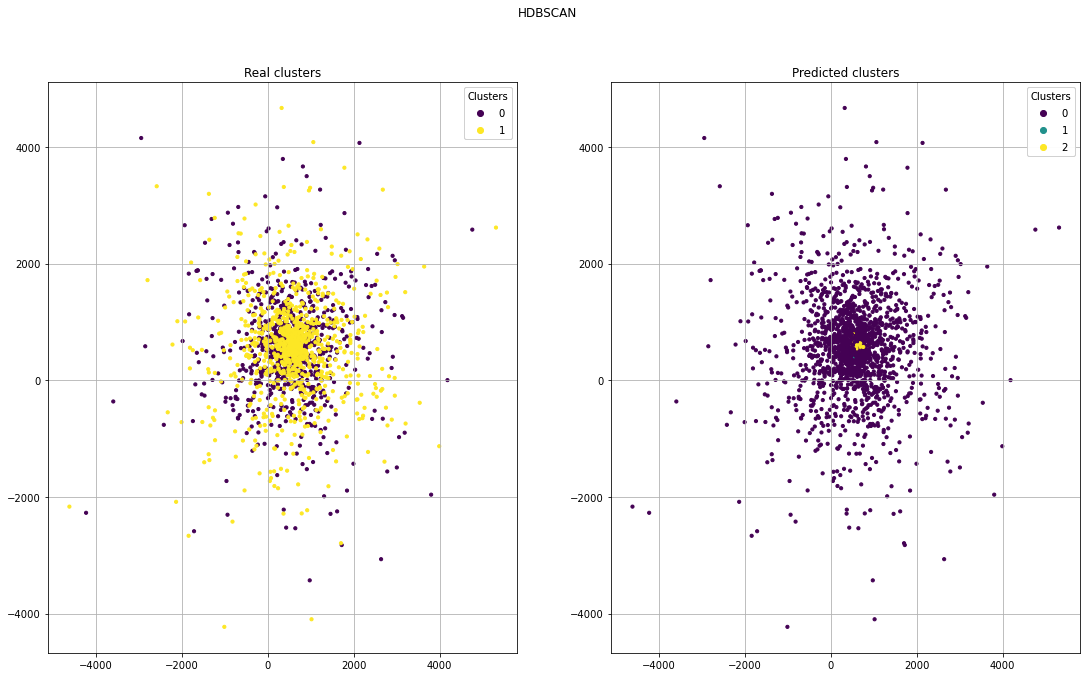

In [18]:
print("=========== HDBSCAN ===========")
start = time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=70)
y_pred = clusterer.fit_predict(Xbig)
end = time.time()
print("Clustering time {}s".format(end-start))
y_pred = [i+1 for i in y_pred]
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))
print("Number of clusters : {}".format(len(set(y_pred))))
print("Adjusted Rand index:",metrics.adjusted_rand_score(ybig, y_pred))
print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ybig, y_pred))
print("V-measure:",metrics.v_measure_score(ybig, y_pred))
print("================================")

fig, axs = plt.subplots(1,2)
fig.suptitle('HDBSCAN')
fig.set_size_inches(18.5, 10.5)

scatter = axs[0].scatter(Xbig[:,0],Xbig[:,1], c=ybig,  s=10)

# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[0].add_artist(legend1)
axs[0].grid(True)
axs[0].set_title('Real clusters')

###########################################################

axs[1].set_title('Predicted clusters')

scatter = axs[1].scatter(Xbig[:,0],Xbig[:,1], c=y_pred,  s=10)

# produce a legend with the unique colors from the scatter
legend2 = axs[1].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[1].add_artist(legend2)
axs[1].grid(True)

plt.show()


Ελάχιστα καλύτερο απο το DBSCAN από την απόψη όταν δεν βάζει όλα τα δείγματα σε ένα cluster, αλλά πάλι έχουμε πολύ χαμηλές μετρικές και πολύ μέτρια αποτελέσματα, καθώς πάλι σχεδόν όλα τα δείγματα ταξινομούνται σε ένα cluster (Μώβ (0)). Επίσης η μέθοδος HDBSCAN δεν μας δίνει 2 clusters, οποία τιμή και να δώσουμε στην παράμετρο min_cluster_size.

#### **SOM**

============= SOM ==============
{0: 1360, 1: 688}
Clustering time 0.26700448989868164s
Adjusted Rand index: 0.0019491126474297318
Adjusted Mutual information: 0.001641612120067315
V-measure: 0.0020080503979094657


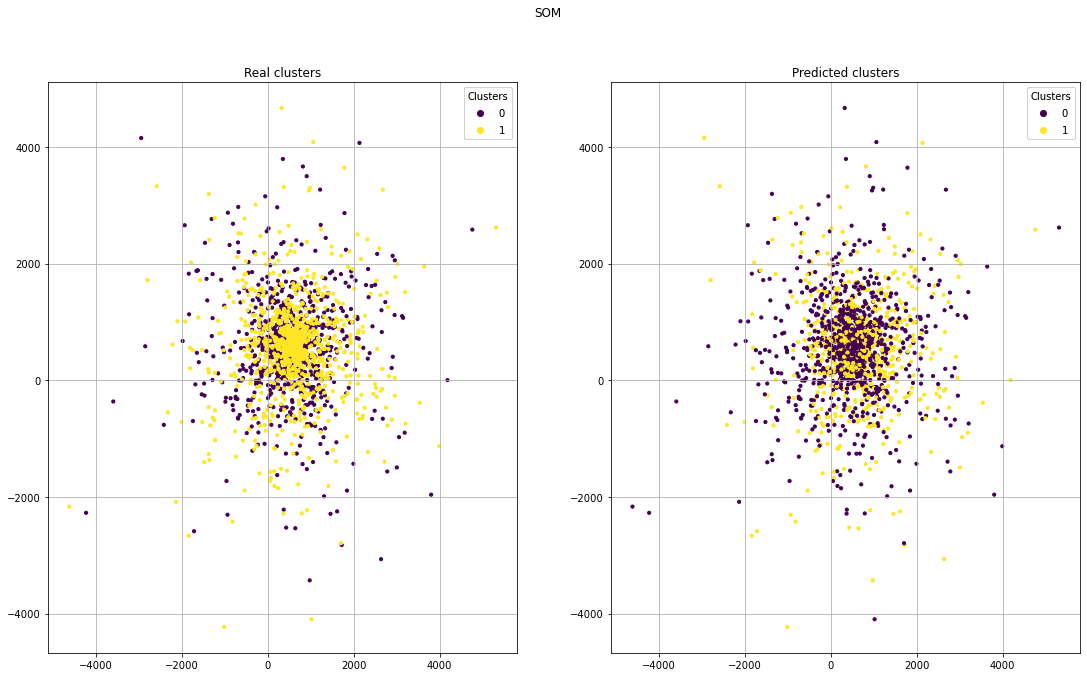

In [19]:
print("============= SOM ==============")
start = time.time()
som = SOM(m=n_clusters_big, n=1, dim=128)
som.fit(Xbig)
y_pred = som.predict(Xbig)
end = time.time()
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))
print("Clustering time {}s".format(end-start))
print("Adjusted Rand index:",metrics.adjusted_rand_score(ybig, y_pred))
print("Adjusted Mutual information:",metrics.adjusted_mutual_info_score(ybig, y_pred))
print("V-measure:",metrics.v_measure_score(ybig, y_pred))

print("================================")

fig, axs = plt.subplots(1,2)
fig.suptitle('SOM')
fig.set_size_inches(18.5, 10.5)
fig.set_size_inches(18.5, 10.5)

scatter = axs[0].scatter(Xbig[:,0],Xbig[:,1], c=ybig,  s=10)

# produce a legend with the unique colors from the scatter
legend1 = axs[0].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[0].add_artist(legend1)
axs[0].grid(True)
axs[0].set_title('Real clusters')

###########################################################

axs[1].set_title('Predicted clusters')

scatter = axs[1].scatter(Xbig[:,0],Xbig[:,1], c=y_pred,  s=10)

# produce a legend with the unique colors from the scatter
legend2 = axs[1].legend(*scatter.legend_elements(),loc="upper right", title="Clusters")
axs[1].add_artist(legend2)
axs[1].grid(True)

plt.show()

O SOM δίνει πολύ χαμηλές μετρικές, αλλά το clustering είναι πολύ πιο ομοιόμορφο σε σχέση με τις άλλες μεθόδους (με εξαίρεση την Κ-means), όπως βλέπουμε τόσο στην απεικόνιση των δυο πρώτων διαστάσεων και στη εκτύπωση των αριθμήσεων για κάθε cluster ({0: 1360, 1: 688}). Ωστόσο με βάση τις μετρικές, ομαδοποιεί τα λάθος δείγματα.

Στη συνέχεια, θα παρουσιάσουμε σε ένα πίνακα markdown, τις τιμές των μετρικών για όλους τους αλγορίθμους:

| Ταξινομητές | Adjusted Rand Index |Adjusted Mutual Information |V-measure |Clustering Time|
| --- | --- |--- | --- |--- |
| k-Means | 42.65% |33.44% |33.47% | 0.0684s|
| HAC (Single) | 0 |0 |0.09% | 0.248s|
| HAC (Average) | 0 |0 |0.09% |0.256s |
| HAC (Complete) |0 |0.09%|0.19% |0.265s |
| HAC (Ward) |0 |0|0.09%|0.269s |
| GMM | 0 |0 |0.09% |0.071s |
| DBSCAN| 0 |0.09% |0.19%|0.0695s |
| HDBSCAN | 0.5% | 9.95% |10% | 0.85s|
| SOM |0.084%|0.06% |0.1% | 0.4125s|

Με βάση τα παραπάνω αποτελέσματα ο χειρότερος αλγόριθμος είναι o HAC με μέθοδο Single και ο καλύτερος είναι o k-Means. Θα υπολογίσουμε και θα σχεδιάσουμε το πίνακα σύγχυσης για τους δύο αλγορίθμους.

======== HAC 'Single' ========
[[1023    1]
 [1024    0]]
============== KMeans =============
[[847 177]
 [178 846]]


Text(0.5, 1.0, 'Best algorithm (KMeans) confusion matrix')

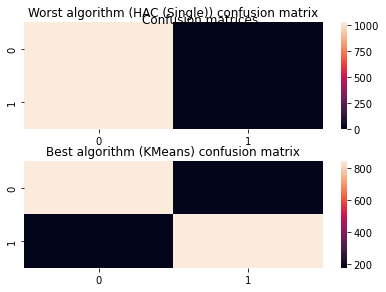

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import fastcluster

print ("======== HAC 'Single' ========")
tree = fastcluster.linkage(Xbig,method= 'single')
worst = scipy.cluster.hierarchy.fcluster(tree,t= n_clusters_big, criterion ='maxclust') # Return prediction_labels
worst = [i-1 for i in worst]
w_conf = confusion_matrix(ybig, worst)
print(w_conf,end='\n')

print("============== KMeans =============")
kmeans = KMeans(n_clusters = n_clusters_big, random_state=42).fit(Xbig)
best = kmeans.predict(Xbig)
b_conf = confusion_matrix(ybig, best)
print(b_conf,end='\n')

fig, axs = plt.subplots(2,1)
fig.tight_layout()
fig.suptitle('Confusion matrices')
sns.heatmap(w_conf,ax = axs[0])
axs[0].set_title('Worst algorithm (HAC (Single)) confusion matrix')
sns.heatmap(b_conf,ax = axs[1])
axs[1].set_title('Best algorithm (KMeans) confusion matrix')

Παρατηρούμε ότι ο HAC ταξινομεί σχεδόν όλα τα δείγματα στο cluster 0, όπως είδαμε και στην αντίστοιχη γραφική. Ο k-means βλέπουμε ότι έχει διαγώνιο πίνακα σύγχυσης, δηλαδή ισοκατανέμει τα δείγματα σε δύο clusters.

Με βάση την παραπάνω μελέτη, ο βέλτιστος αλγόριθμος clustering είναι ο k-Means.